In [23]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import pickle
import pandas as pd
import numpy as np
from psm_causal_effects import psm_causal_effects

# read data
with open('data.dat', 'rb') as f:
    data, subjects = pickle.load(f)
f.close()

# adding subject ids
for i in range(len(data)):
    data[i]['subject'] = pd.Series(np.repeat(subjects[i],data[i].shape[0],axis=0), index=data[i].index, dtype=str)

del subjects

# concatenatig into a single dataframe
data_all = pd.concat(data, axis=0)
data_all = data_all.reset_index(drop=True)

# keeping only relevant variables
data_all = data_all[['subject','mood','mood_prev','quality']]

# removing nan rows
data_all = data_all.dropna()
data_all = data_all.reset_index(drop=True)

# load assessments
with open('../CS120/Assessment/assessment.dat', 'rb') as f:
    ass = pickle.load(f)
f.close()

### Calculating Personal Model Params

In [19]:
# calculating personal model parameters

betas_m2s = np.zeros([len(data),2])
betas_s2m = np.zeros([len(data),2])
for iSubj in range(len(data)):
    if data[iSubj].shape[0] ==0:
        betas_m2s[iSubj, :] = np.array([np.nan, np.nan])
        betas_s2m[iSubj, :] = np.array([np.nan, np.nan])
    else:
        md = smf.glm('quality ~ mood_prev', data[iSubj])
        mdf = md.fit()
        betas_m2s[iSubj, :] = mdf.params
        md = smf.glm('mood ~ quality', data[iSubj])
        mdf = md.fit()
        betas_s2m[iSubj, :] = mdf.params

### Personal + Global (effect of mood on sleep)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 9126
Model:                            GLM   Df Residuals:                     9124
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   2.43810920302
Method:                          IRLS   Log-Likelihood:                -17015.
Date:                Fri, 07 Apr 2017   Deviance:                       22245.
Time:                        15:05:49   Pearson chi2:                 2.22e+04
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2623      0.057     21.967      0.000       1.150       1.375
mood_prev      0.6363      0.011     57.966      0.0

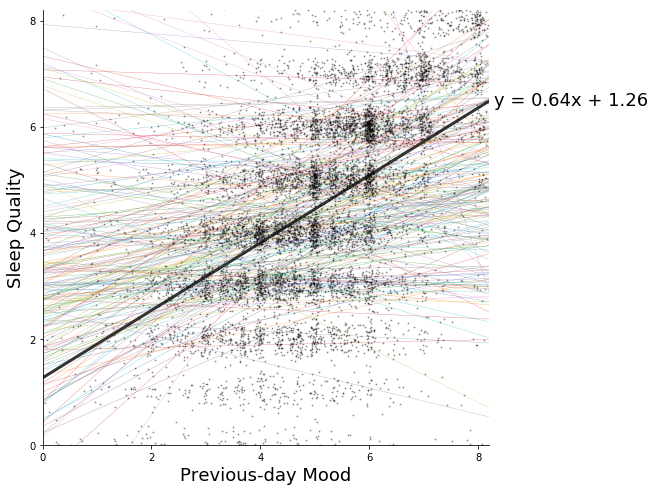

In [4]:
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

md = smf.glm('quality ~ mood_prev', data_all)
mdf = md.fit()
print(mdf.summary())
print(pearsonr(data_all['mood_prev'],data_all['quality']))

plt.figure(figsize=[8,8])
for iSubj in range(len(data)):
    plt.plot([0,8.2], [betas_m2s[iSubj, 0],betas_m2s[iSubj,0]+betas_m2s[iSubj,1]*8.2], linewidth=.3, alpha=.75)
plt.plot([0,8.2], [mdf.params[0],mdf.params[0]+mdf.params[1]*8.2], color=(.2, .2,.2), linewidth=3, alpha=1)
plt.plot(data_all['mood_prev']+0.075*np.random.randn(data_all.shape[0]),data_all['quality']+0.2*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.3)
plt.xlabel('Previous-day Mood',fontsize=18)
plt.ylabel('Sleep Quality',fontsize=18)
plt.xlim([0,8.2])
plt.ylim([0,8.2])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));

plt.text(8.3,6.4,'y = {:.2}x + {:.3}'.format(mdf.params[1],mdf.params[0]),fontsize=18)


### Personal + Global (effect of sleep on mood)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mood   No. Observations:                 9126
Model:                            GLM   Df Residuals:                     9124
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   1.39930263752
Method:                          IRLS   Log-Likelihood:                -14481.
Date:                Fri, 07 Apr 2017   Deviance:                       12767.
Time:                        15:05:53   Pearson chi2:                 1.28e+04
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8396      0.033     86.970      0.000       2.776       2.904
quality        0.4913      0.007     72.461      0.0

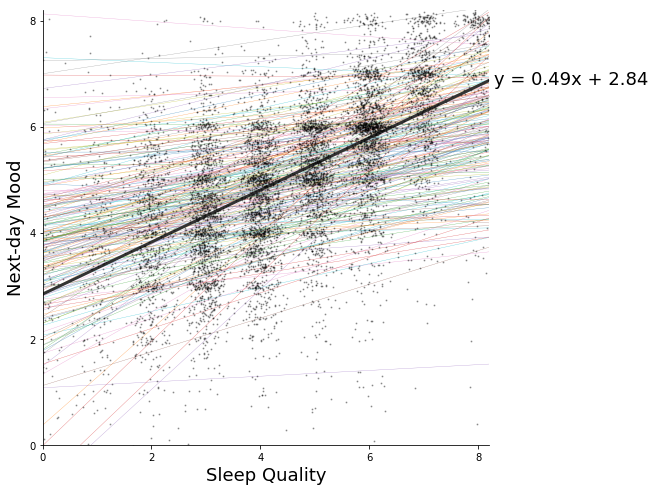

In [5]:
from scipy.stats.stats import pearsonr

md = smf.glm('mood ~ quality', data_all)
mdf = md.fit()
print(mdf.summary())
print(pearsonr(data_all['quality'],data_all['mood']))

plt.figure(figsize=[8,8])
for iSubj in range(len(data)):
    plt.plot([0,8.2], [betas_s2m[iSubj, 0],betas_s2m[iSubj,0]+betas_s2m[iSubj,1]*8.2], linewidth=.3, alpha=.75)
plt.plot([0,8.2], [mdf.params[0],mdf.params[0]+mdf.params[1]*8.2], color=(.2,.2,.2), linewidth=3)
plt.plot(data_all['quality']+0.2*np.random.randn(data_all.shape[0]),data_all['mood']+0.075*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.3)
plt.xlabel('Sleep Quality',fontsize=18)
plt.ylabel('Next-day Mood',fontsize=18)
plt.xlim([0,8.2])
plt.ylim([0,8.2])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));

plt.text(8.3,6.8,'y = {:.2}x + {:.3}'.format(mdf.params[1],mdf.params[0]),fontsize=18)


### Mixed Effects

In [24]:
# sleep on mood
md = smf.mixedlm('mood ~ quality', data_all, groups=data_all['subject'], re_formula="~quality")
# md = smf.mixedlm('mood ~ quality', data_all, groups=data_all['subject'])
mdf = md.fit(method='cg')
print('Effect of sleep quality on mood:')
print(mdf.summary())

# mood on sleep
md = smf.mixedlm('quality ~ mood_prev', data_all, groups=data_all['subject'], re_formula="~mood_prev")
# md = smf.mixedlm('quality ~ mood_prev', data_all, groups=data_all['subject'])
mdf = md.fit(method='cg')
print('Effect of mood on sleep quality:')
print(mdf.summary())

Effect of sleep quality on mood:
               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    mood       
No. Observations:      9162       Method:                REML       
No. Groups:            207        Scale:                 0.7342     
Min. group size:       4          Likelihood:            -12094.6940
Max. group size:       133        Converged:             Yes        
Mean group size:       44.3                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  3.898    0.093 41.817 0.000  3.715  4.081
quality                    0.260    0.013 20.051 0.000  0.234  0.285
Intercept RE               1.467    0.209                           
Intercept RE x quality RE -0.119    0.024                           
quality RE       

/usr/local/lib/python3.4/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Effect of mood on sleep quality:
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     quality    
No. Observations:      9162        Method:                 REML       
No. Groups:            207         Scale:                  1.6907     
Min. group size:       4           Likelihood:             -15802.9633
Max. group size:       133         Converged:              Yes        
Mean group size:       44.3                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.160    0.124 25.571 0.000  2.917  3.402
mood_prev                    0.256    0.021 12.049 0.000  0.214  0.297
Intercept RE                 1.557    0.207                           
Intercept RE x mood_prev RE -0.146    0.031                  

In [98]:
# significant difference between the slopes of the mixed models

from scipy.stats import t

n1= 207.0
m1 = 0.383
se1 = 0.073

n2 = 207.0
m2 = 0.254
se2 = 0.019

s1 = se1*np.sqrt(n1)
s2 = se2*np.sqrt(n2)
sp = np.sqrt(((n1-1)*s1*s1+(n2-1)*s2*s2)/(n1+n2-2))

tstat = (m1-m2)/(sp*np.sqrt(1/n1+1/n2))
df = n1+n2-2

print('P = '+str(1-t.cdf(tstat, df)))

P = 0.0439957273866


### Didactics

pooled beta = 0.794491104757
mixed beta = 0.0995059205025


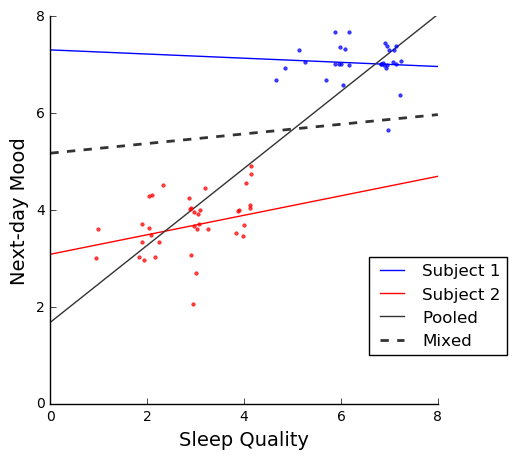

In [73]:
from psm_causal_effects import psm_causal_effects
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=1)

noise_amp_mood = 0.05#0.075
noise_amp_quality = 0.15#0.2

ind1 = 49#6
ind2 = 149#100

# removing nan rows
data1 = data[ind1].dropna()
data1 = data1.reset_index(drop=True)
data2 = data[ind2].dropna()
data2 = data2.reset_index(drop=True)

#personal models
plt.figure(figsize=[5,5])
plt.plot([0,8], [betas_s2m[ind1, 0]+betas_s2m[ind1,1]*0,betas_s2m[ind1,0]+betas_s2m[ind1,1]*8], linewidth=1, alpha=1, color=(0,0,1), linestyle='-')
plt.plot([0,8], [betas_s2m[ind2, 0]+betas_s2m[ind2,1]*0,betas_s2m[ind2,0]+betas_s2m[ind2,1]*8], linewidth=1, alpha=1, color=(1,0,0), linestyle='-')

data_p  = pd.concat([data1, data2],axis=0)
data_p = data_p[['subject','mood','quality']]

#pooled regression
md = smf.glm('mood ~ quality', data_p)
mdf = md.fit()
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=1, linestyle='-')
print 'pooled beta = '+str(mdf.params[1])

#mixed linear models regression
md = smf.mixedlm('mood ~ quality', data_p, groups=data_p['subject'], re_formula="~quality")
mdf = md.fit() 
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=2, linestyle='--')
print 'mixed beta = '+str(mdf.params[1])

plt.xlabel('Sleep Quality', fontsize=14)
plt.ylabel('Next-day Mood', fontsize=14)
plt.xlim([0,8])
plt.ylim([0,8])

plt.legend(['Subject 1','Subject 2','Pooled','Mixed'],bbox_to_anchor=(1.2, .4))

#noise vectors
n_quality_1 = noise_amp_quality*np.random.randn(data1.shape[0])
n_quality_2 = noise_amp_quality*np.random.randn(data2.shape[0])
n_mood_1 = noise_amp_mood*np.random.randn(data1.shape[0])
n_mood_2 = noise_amp_mood*np.random.randn(data2.shape[0])

plt.plot(data1['quality']+n_quality_1,data1['mood']+n_mood_1,'.',markersize=5,\
        markeredgecolor =(0,0,1),alpha=.75,markerfacecolor=(0,0,1))

plt.plot(data2['quality']+n_quality_2,data2['mood']+n_mood_2,'.',markersize=5,\
        markeredgecolor =(1,0,0),alpha=.75,markerfacecolor=(1,0,0))

plt.ylim([0,8])
plt.xlim([0,8])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));